In [1]:
!pip install keras-vggface

In [2]:
!pip install opencv-python
!pip install --user tqdm 
!pip install astor 

In [3]:
!pip install tensorflow==2.2.0 --user

In [5]:
!pip install keras==2.2.2

  Using cached Keras-2.2.2-py2.py3-none-any.whl (299 kB)
  Using cached Keras_Preprocessing-1.0.2-py2.py3-none-any.whl (26 kB)
  Using cached Keras_Applications-1.0.4-py2.py3-none-any.whl (43 kB)
  Attempting uninstall: keras-preprocessing
    Found existing installation: Keras-Preprocessing 1.1.2
    Uninstalling Keras-Preprocessing-1.1.2:
      Successfully uninstalled Keras-Preprocessing-1.1.2
  Attempting uninstall: keras-applications
    Found existing installation: Keras-Applications 1.0.8
    Uninstalling Keras-Applications-1.0.8:
      Successfully uninstalled Keras-Applications-1.0.8
  Attempting uninstall: keras
    Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


ERROR: -ensorflow-cpu 1.15.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
ERROR: -ensorflow-cpu 1.15.0 has requirement keras-applications>=1.0.8, but you'll have keras-applications 1.0.4 which is incompatible.
ERROR: -ensorflow-cpu 1.15.0 has requirement keras-preprocessing>=1.0.5, but you'll have keras-preprocessing 1.0.2 which is incompatible.
ERROR: -ensorflow-cpu 1.15.0 has requirement tensorboard<1.16.0,>=1.15.0, but you'll have tensorboard 2.2.2 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement keras-preprocessing>=1.1.0, but you'll have keras-preprocessing 1.0.2 which is incompatible.


In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import math
import copy
import numpy as np

from keras.models import Sequential, Model
from keras.layers import Input, Dense, Flatten, Dropout, Activation, Lambda, Permute, Reshape
from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from keras_vggface.vggface import VGGFace
from keras_vggface import utils
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob
import pandas as pd
import cv2
import scipy.misc
import matplotlib.pyplot as plt
from tqdm import tqdm

Using TensorFlow backend.


# load dataset


In [7]:
base_path = './Input/realfake/'
image_gen = ImageDataGenerator(rescale=1./255.)
batch_size = 64
train_flow = image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)
valid_flow = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)
test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode='binary'
)

Found 1152 images belonging to 2 classes.
Found 288 images belonging to 2 classes.
Found 288 images belonging to 2 classes.


# Custom Architecture

In [8]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dropout, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.python.keras.layers.normalization import BatchNormalization
"""
    Propsoed CNN architecture.
    
"""

model = Sequential()

# Pamameters Initialization
input_shape = (224,224,3)
activation = 'relu'
padding = 'same'
droprate = 0.1
epsilon=0.001

model = Sequential()
model.add(BatchNormalization(input_shape=input_shape))
model.add(Conv2D(filters=16, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))


model.add(Conv2D(filters=32, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(Conv2D(filters=64, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(Conv2D(filters=128, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(Conv2D(filters=256, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(Conv2D(filters=512, kernel_size=3, activation=activation, padding=padding))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization(epsilon=epsilon))
model.add(Dropout(droprate))

model.add(GlobalAveragePooling2D())
#model.add(Flatten())
#model.add(Dense(256, kernel_initializer='glorot_normal', activation='relu'))
#model.add(Dropout(0.5))
          
#model.add(Dense(128, kernel_initializer='glorot_normal', activation='relu'))
#model.add(Dropout(0.5))
#model.add(Dropout(droprate))
model.add(Dense(1, activation='sigmoid'))

model.summary() # Summary of the architecture

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 16)      64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 56, 56, 32)       

# Model Compile

In [9]:
# Parameters Initialization
from keras.optimizers import rmsprop,SGD,Adam,Adadelta

opt = Adam(lr=0.0001, decay=1e-6)

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

# Train Custom Model

In [17]:
train_steps = 200//batch_size
valid_steps = 200//batch_size
history = model.fit_generator(
    train_flow,
    epochs=3,
    steps_per_epoch = train_steps,
    validation_data = valid_flow,
    validation_steps = valid_steps
)

Epoch 1/3
3/3 [==============================] - 21s 7s/step - loss: 0.6554 - accuracy: 0.6094 - val_loss: 0.7241 - val_accuracy: 0.5063
Epoch 2/3
3/3 [==============================] - 21s 7s/step - loss: 0.6569 - accuracy: 0.6146 - val_loss: 0.7742 - val_accuracy: 0.4688
Epoch 3/3
3/3 [==============================] - 21s 7s/step - loss: 0.6307 - accuracy: 0.6510 - val_loss: 0.7368 - val_accuracy: 0.5063


In [18]:
model.save("dataset2_model.h5") # save model

In [19]:
"""
Plot the training and validation loss
epochs - list of epoch numbers
loss - training loss for each epoch
val_loss - validation loss for each epoch
"""
def plot_loss(epochs, loss, val_loss):
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'orange', label = 'Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()
"""
Plot the training and validation accuracy
epochs - list of epoch numbers
acc - training accuracy for each epoch
val_acc - validation accuracy for each epoch
"""
def plot_accuracy(epochs, acc, val_acc):
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label = 'Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

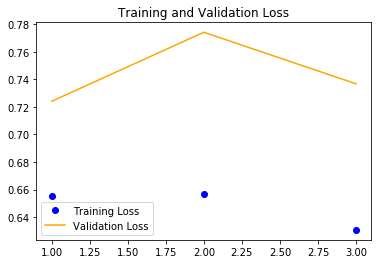

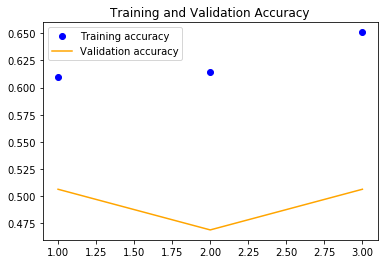

In [21]:
plot_loss(range(1, len(loss) + 1), loss, val_loss)
plot_accuracy(range(1, len(loss) + 1), acc, val_acc)

# Predict and Evaluate

In [ ]:
y_pred = model.predict(test_flow)
y_test = test_flow.classes

In [ ]:
from sklearn import metrics
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))